<a href="https://colab.research.google.com/github/prachipancholi1/SKin-Lesion-Detection-phd/blob/main/DermNet_Image_Classssification_65_35_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Table of contents**<a id='toc0_'></a>    
- [Import Libraries](#toc1_1_1_)    
- [Defined Canny Edge Detector Class](#toc1_1_2_)    
- [Load Images](#toc1_1_3_)    
- [Train-Test Split](#toc1_1_4_)    
- [Model Training](#toc1_1_5_)    
- [Model Evaluation](#toc1_1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -a '/content/drive/MyDrive/Prachi/' '/content/'

In [3]:
import zipfile
import os
# loading and extracting data
os.makedirs("/content/data/", exist_ok=True)

zip_ref = zipfile.ZipFile("/content/Prachi/Train.zip", 'r')
zip_ref.extractall("/content/data/")
zip_ref.close()

In [4]:
!pip install torch torchvision timm dagshub mlflow
!pip install torch-summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 830.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### <a id='toc1_1_1_'></a>[Import Libraries](#toc0_)

In [5]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, matthews_corrcoef, ConfusionMatrixDisplay
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import mlflow.pytorch
import os
from tqdm import tqdm
import dagshub
#  dagshub.init(repo_owner='shriganesh.patel', repo_name='Dermnet', mlflow=True)
dagshub.init(repo_owner='prachipancholi1', repo_name='Dermnet', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=b944a372-c55e-46ce-b313-a53655a3415a&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=65041eb2cad010fa2a3af46c66728433770859c576db1f5f934d65b3902c928f




Accessing as prachipancholi1

Initialized MLflow to track repo "prachipancholi1/Dermnet"

Repository prachipancholi1/Dermnet initialized!

In [11]:
# Step 1: Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (ResNet's expected input size)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize based on ImageNet stats
])

In [12]:
# Load the dataset (all images)
dataset = datasets.ImageFolder(root='/content/data/Train', transform=transform)

In [13]:
# Verify class names
print("Classes:", dataset.classes)  # Should print ['Eczema', 'Psoriasis', 'Seborrheic_Keratoses']
num_classes = len(dataset.classes)

Classes: ['Eczema', 'Psoriasis', 'Seborrheic_Keratoses']


In [14]:
# Step 3: Create indices and split with `train_test_split`
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.35, random_state=42)

# Create Subsets
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

In [15]:
# Step 3: Create Data Loader for training and test dataset
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

In [16]:
# Step 4: Load the pre-trained Resnet model using timm
resnet = timm.create_model('resnet18', pretrained=True) # Load ResNet18 from timm

# Freeze all layers ex[ect the final fully connected layer
for param in resnet.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(dataset.classes))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [17]:
# Step 6: Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [18]:
print(device)

cuda


In [19]:
# print the model summary
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Print model summary
print(summary(resnet, input_size=(3, 224, 224)))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  (36,864)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Identity: 3-3                --
|    |    └─ReLU: 3-4                    --
|    |    └─Identity: 3-5                --
|    |    └─Conv2d: 3-6                  (36,864)
|    |    └─BatchNorm2d: 3-7             (128)
|    |    └─ReLU: 3-8                    --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-9                  (36,864)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Identity: 3-11               --
|    |    └─ReLU: 3-12                   --
|    |    └─Identity: 3-13               --
|    |    └─Conv2d: 3-14            

In [20]:
# To Vizulize the model installation of this package
!pip install graphviz torchviz

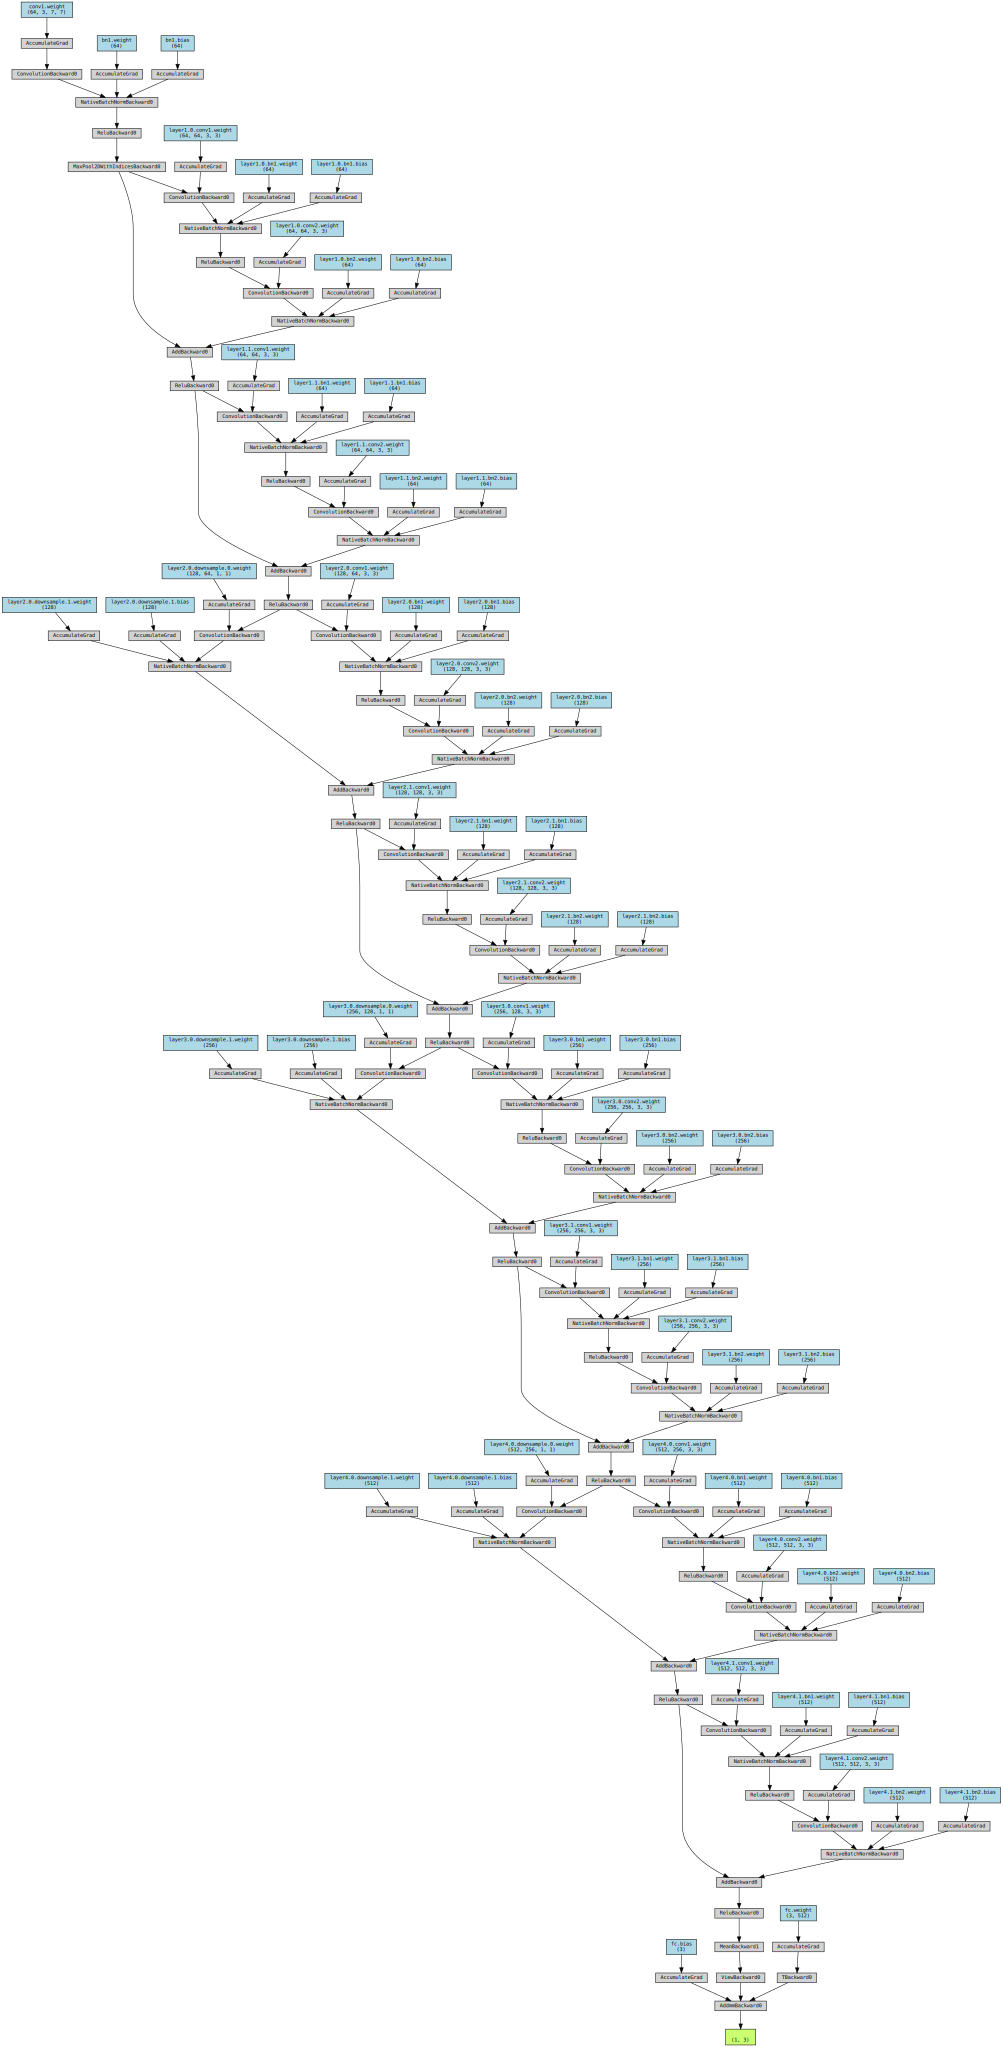

In [21]:
import torch
import timm
from torchviz import make_dot

# Load the ResNet model
resnet = timm.create_model('resnet18', pretrained=True, num_classes=3)

# Create a dummy input tensor (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224)

# Perform a forward pass to get model output
output = resnet(dummy_input)

# Generate the visualization
dot = make_dot(output, params=dict(resnet.named_parameters()))
dot.render("resnet_model", format="png")  # Saves the visualization as a PNG file
dot  # Display the graph in Jupyter Notebook

In [22]:
# Step 8: Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

In [23]:
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")  # Should be 3 for (Eczema, Psoriasis, Seborrheic_Keratoses)

Number of classes: 3


In [ ]:
# @title Default title text
# # Step 9: Initialize MLflow
# mlflow.set_experiment('resnet_experiment')

# with mlflow.start_run():
#     mlflow.log_param("Model", "ResNet18")

#     # Step 10: Train Model with tqdm Progress Bar
#     num_epochs = 50
#     for epoch in range(num_epochs):
#         resnet.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         progress_bar = tqdm(train_dataloder, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

#         for inputs, labels in progress_bar:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = resnet(inputs)
#             loss = criterion(outputs, labels)

#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             progress_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

#         epoch_loss = running_loss / len(train_dataloder)
#         epoch_acc = 100 * correct / total

#         mlflow.log_metric("train_loss", epoch_loss, step=epoch)
#         mlflow.log_metric("train_accuracy", epoch_acc, step=epoch)

#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

#     # Step 11: Evaluate Model
#     resnet.eval()
#     y_pred = []
#     y_true = []

#     with torch.no_grad():
#         for inputs, labels in test_dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = resnet(inputs)

#             _, predicted = torch.max(outputs, 1)
#             y_pred.extend(predicted.cpu().numpy())
#             y_true.extend(labels.cpu().numpy())

#     # Step 12: Compute Metrics
#     classification_rep = classification_report(y_true, y_pred, target_names=dataset.classes, output_dict=True)
#     print(classification_rep)
#     cm = confusion_matrix(y_true, y_pred)

#     # Log classification report
#     with open("classification_report.txt", "w") as f:
#         f.write(str(classification_rep))
#     mlflow.log_artifact("classification_report.txt")

#     # Log Confusion Matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
#     disp.plot(cmap="Blues")
#     plt.savefig("confusion_matrix.png")
#     mlflow.log_artifact("confusion_matrix.png")

#     # Log additional metrics
#     mlflow.log_metric("cohen_kappa", cohen_kappa_score(y_true, y_pred))
#     mlflow.log_metric("matthews_corrcoef", matthews_corrcoef(y_true, y_pred))

#     # Log the trained model
#     mlflow.pytorch.log_model(resnet, "model")

#     print("\nFinal Test Accuracy:", 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true))
#     print(f"Cohen Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")
#     print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_true, y_pred):.4f}")

Epoch 1/50: 100%|██████████| 195/195 [00:52<00:00,  3.71it/s, acc=55.5, loss=0.889]


Epoch 1/50, Loss: 0.9473, Accuracy: 55.54%, Precision: 0.5659, Recall: 0.5510, F1-score: 0.5529


Epoch 2/50: 100%|██████████| 195/195 [00:40<00:00,  4.82it/s, acc=62.9, loss=0.742]


Epoch 2/50, Loss: 0.8394, Accuracy: 62.91%, Precision: 0.6302, Recall: 0.6279, F1-score: 0.6278


Epoch 3/50: 100%|██████████| 195/195 [00:41<00:00,  4.70it/s, acc=63.7, loss=0.872]


Epoch 3/50, Loss: 0.8049, Accuracy: 63.68%, Precision: 0.6363, Recall: 0.6364, F1-score: 0.6354


Epoch 4/50: 100%|██████████| 195/195 [00:40<00:00,  4.79it/s, acc=65.9, loss=0.961]


Epoch 4/50, Loss: 0.7782, Accuracy: 65.92%, Precision: 0.6602, Recall: 0.6571, F1-score: 0.6573


Epoch 5/50: 100%|██████████| 195/195 [00:40<00:00,  4.79it/s, acc=66.7, loss=0.685]


Epoch 5/50, Loss: 0.7577, Accuracy: 66.74%, Precision: 0.6694, Recall: 0.6659, F1-score: 0.6665


Epoch 6/50: 100%|██████████| 195/195 [00:41<00:00,  4.66it/s, acc=68, loss=0.816]


Epoch 6/50, Loss: 0.7404, Accuracy: 67.98%, Precision: 0.6804, Recall: 0.6790, F1-score: 0.6789


Epoch 7/50: 100%|██████████| 195/195 [00:40<00:00,  4.80it/s, acc=68.4, loss=0.623]


Epoch 7/50, Loss: 0.7321, Accuracy: 68.39%, Precision: 0.6849, Recall: 0.6834, F1-score: 0.6834


Epoch 8/50: 100%|██████████| 195/195 [00:40<00:00,  4.79it/s, acc=68.7, loss=0.721]


Epoch 8/50, Loss: 0.7320, Accuracy: 68.71%, Precision: 0.6882, Recall: 0.6857, F1-score: 0.6861


Epoch 9/50: 100%|██████████| 195/195 [00:40<00:00,  4.77it/s, acc=69.4, loss=0.723]


Epoch 9/50, Loss: 0.7230, Accuracy: 69.40%, Precision: 0.6953, Recall: 0.6934, F1-score: 0.6938


Epoch 10/50: 100%|██████████| 195/195 [00:41<00:00,  4.75it/s, acc=69.1, loss=0.741]


Epoch 10/50, Loss: 0.7137, Accuracy: 69.05%, Precision: 0.6909, Recall: 0.6897, F1-score: 0.6897


Epoch 11/50: 100%|██████████| 195/195 [00:40<00:00,  4.87it/s, acc=69.3, loss=0.603]


Epoch 11/50, Loss: 0.7061, Accuracy: 69.29%, Precision: 0.6939, Recall: 0.6919, F1-score: 0.6923


Epoch 12/50: 100%|██████████| 195/195 [00:39<00:00,  4.88it/s, acc=69.2, loss=0.67]


Epoch 12/50, Loss: 0.7022, Accuracy: 69.20%, Precision: 0.6933, Recall: 0.6913, F1-score: 0.6918


Epoch 13/50: 100%|██████████| 195/195 [00:39<00:00,  4.94it/s, acc=69.7, loss=0.673]


Epoch 13/50, Loss: 0.6975, Accuracy: 69.74%, Precision: 0.7000, Recall: 0.6960, F1-score: 0.6971


Epoch 14/50: 100%|██████████| 195/195 [00:40<00:00,  4.83it/s, acc=70.5, loss=0.573]


Epoch 14/50, Loss: 0.6857, Accuracy: 70.48%, Precision: 0.7051, Recall: 0.7042, F1-score: 0.7042


Epoch 15/50: 100%|██████████| 195/195 [00:40<00:00,  4.82it/s, acc=69.9, loss=0.594]


Epoch 15/50, Loss: 0.6848, Accuracy: 69.90%, Precision: 0.7000, Recall: 0.6981, F1-score: 0.6986


Epoch 16/50: 100%|██████████| 195/195 [00:40<00:00,  4.77it/s, acc=70, loss=0.632]


Epoch 16/50, Loss: 0.6828, Accuracy: 69.98%, Precision: 0.7004, Recall: 0.6993, F1-score: 0.6995


Epoch 17/50: 100%|██████████| 195/195 [00:40<00:00,  4.86it/s, acc=70.6, loss=0.564]


Epoch 17/50, Loss: 0.6782, Accuracy: 70.59%, Precision: 0.7075, Recall: 0.7053, F1-score: 0.7058


Epoch 18/50: 100%|██████████| 195/195 [00:40<00:00,  4.77it/s, acc=70.9, loss=0.606]


Epoch 18/50, Loss: 0.6806, Accuracy: 70.93%, Precision: 0.7095, Recall: 0.7091, F1-score: 0.7091


Epoch 19/50: 100%|██████████| 195/195 [00:40<00:00,  4.83it/s, acc=70.5, loss=0.603]


Epoch 19/50, Loss: 0.6751, Accuracy: 70.54%, Precision: 0.7056, Recall: 0.7054, F1-score: 0.7051


Epoch 20/50: 100%|██████████| 195/195 [00:40<00:00,  4.78it/s, acc=70.7, loss=0.8]


Epoch 20/50, Loss: 0.6765, Accuracy: 70.72%, Precision: 0.7087, Recall: 0.7062, F1-score: 0.7069


Epoch 21/50: 100%|██████████| 195/195 [00:40<00:00,  4.80it/s, acc=70.8, loss=0.628]


Epoch 21/50, Loss: 0.6749, Accuracy: 70.85%, Precision: 0.7088, Recall: 0.7083, F1-score: 0.7082


Epoch 22/50: 100%|██████████| 195/195 [00:41<00:00,  4.71it/s, acc=71.5, loss=0.541]


Epoch 22/50, Loss: 0.6667, Accuracy: 71.51%, Precision: 0.7160, Recall: 0.7150, F1-score: 0.7152


Epoch 23/50: 100%|██████████| 195/195 [00:40<00:00,  4.79it/s, acc=71.2, loss=0.79]


Epoch 23/50, Loss: 0.6684, Accuracy: 71.22%, Precision: 0.7133, Recall: 0.7114, F1-score: 0.7119


Epoch 24/50: 100%|██████████| 195/195 [00:40<00:00,  4.76it/s, acc=71.2, loss=0.688]


Epoch 24/50, Loss: 0.6688, Accuracy: 71.20%, Precision: 0.7126, Recall: 0.7112, F1-score: 0.7115


Epoch 25/50: 100%|██████████| 195/195 [00:40<00:00,  4.77it/s, acc=70.6, loss=0.576]


Epoch 25/50, Loss: 0.6737, Accuracy: 70.64%, Precision: 0.7072, Recall: 0.7058, F1-score: 0.7059


Epoch 26/50: 100%|██████████| 195/195 [00:41<00:00,  4.69it/s, acc=71.5, loss=0.573]


Epoch 26/50, Loss: 0.6609, Accuracy: 71.46%, Precision: 0.7156, Recall: 0.7142, F1-score: 0.7146


Epoch 27/50: 100%|██████████| 195/195 [00:40<00:00,  4.77it/s, acc=71.2, loss=0.528]


Epoch 27/50, Loss: 0.6566, Accuracy: 71.23%, Precision: 0.7118, Recall: 0.7126, F1-score: 0.7119


Epoch 28/50: 100%|██████████| 195/195 [00:40<00:00,  4.83it/s, acc=71.2, loss=0.641]


Epoch 28/50, Loss: 0.6612, Accuracy: 71.19%, Precision: 0.7137, Recall: 0.7107, F1-score: 0.7117


Epoch 29/50: 100%|██████████| 195/195 [00:40<00:00,  4.76it/s, acc=71.5, loss=0.607]


Epoch 29/50, Loss: 0.6554, Accuracy: 71.49%, Precision: 0.7153, Recall: 0.7142, F1-score: 0.7144


Epoch 30/50: 100%|██████████| 195/195 [00:42<00:00,  4.62it/s, acc=71.4, loss=0.684]


Epoch 30/50, Loss: 0.6631, Accuracy: 71.44%, Precision: 0.7153, Recall: 0.7136, F1-score: 0.7140


Epoch 31/50: 100%|██████████| 195/195 [00:41<00:00,  4.74it/s, acc=71.1, loss=0.757]


Epoch 31/50, Loss: 0.6611, Accuracy: 71.12%, Precision: 0.7113, Recall: 0.7114, F1-score: 0.7111


Epoch 32/50: 100%|██████████| 195/195 [00:41<00:00,  4.73it/s, acc=71.9, loss=0.756]


Epoch 32/50, Loss: 0.6534, Accuracy: 71.91%, Precision: 0.7198, Recall: 0.7187, F1-score: 0.7190


Epoch 33/50: 100%|██████████| 195/195 [00:40<00:00,  4.78it/s, acc=72.1, loss=0.631]


Epoch 33/50, Loss: 0.6507, Accuracy: 72.07%, Precision: 0.7210, Recall: 0.7204, F1-score: 0.7205


Epoch 34/50: 100%|██████████| 195/195 [00:42<00:00,  4.54it/s, acc=71.8, loss=0.589]


Epoch 34/50, Loss: 0.6574, Accuracy: 71.80%, Precision: 0.7187, Recall: 0.7174, F1-score: 0.7177


Epoch 35/50: 100%|██████████| 195/195 [00:40<00:00,  4.76it/s, acc=71.7, loss=0.766]


Epoch 35/50, Loss: 0.6525, Accuracy: 71.67%, Precision: 0.7174, Recall: 0.7156, F1-score: 0.7161


Epoch 36/50: 100%|██████████| 195/195 [00:41<00:00,  4.70it/s, acc=71.8, loss=0.59]


Epoch 36/50, Loss: 0.6569, Accuracy: 71.83%, Precision: 0.7194, Recall: 0.7179, F1-score: 0.7185


Epoch 37/50: 100%|██████████| 195/195 [00:40<00:00,  4.77it/s, acc=71.7, loss=0.866]


Epoch 37/50, Loss: 0.6550, Accuracy: 71.68%, Precision: 0.7167, Recall: 0.7170, F1-score: 0.7167


Epoch 38/50: 100%|██████████| 195/195 [00:40<00:00,  4.80it/s, acc=71.7, loss=0.723]


Epoch 38/50, Loss: 0.6597, Accuracy: 71.72%, Precision: 0.7187, Recall: 0.7165, F1-score: 0.7173


Epoch 39/50: 100%|██████████| 195/195 [00:39<00:00,  4.95it/s, acc=71.3, loss=0.971]


Epoch 39/50, Loss: 0.6529, Accuracy: 71.28%, Precision: 0.7139, Recall: 0.7124, F1-score: 0.7128


Epoch 40/50: 100%|██████████| 195/195 [00:40<00:00,  4.78it/s, acc=71.8, loss=0.726]


Epoch 40/50, Loss: 0.6514, Accuracy: 71.81%, Precision: 0.7184, Recall: 0.7180, F1-score: 0.7180


Epoch 41/50: 100%|██████████| 195/195 [00:40<00:00,  4.83it/s, acc=72.7, loss=0.701]


Epoch 41/50, Loss: 0.6454, Accuracy: 72.71%, Precision: 0.7273, Recall: 0.7268, F1-score: 0.7269


Epoch 42/50: 100%|██████████| 195/195 [00:39<00:00,  4.95it/s, acc=72.2, loss=0.687]


Epoch 42/50, Loss: 0.6522, Accuracy: 72.21%, Precision: 0.7229, Recall: 0.7209, F1-score: 0.7215


Epoch 43/50: 100%|██████████| 195/195 [00:39<00:00,  4.89it/s, acc=73, loss=0.48]


Epoch 43/50, Loss: 0.6426, Accuracy: 72.97%, Precision: 0.7303, Recall: 0.7294, F1-score: 0.7296


Epoch 44/50: 100%|██████████| 195/195 [00:39<00:00,  4.89it/s, acc=71.8, loss=0.784]


Epoch 44/50, Loss: 0.6517, Accuracy: 71.76%, Precision: 0.7178, Recall: 0.7175, F1-score: 0.7176


Epoch 45/50: 100%|██████████| 195/195 [00:40<00:00,  4.80it/s, acc=72.2, loss=0.677]


Epoch 45/50, Loss: 0.6417, Accuracy: 72.20%, Precision: 0.7226, Recall: 0.7213, F1-score: 0.7216


Epoch 46/50: 100%|██████████| 195/195 [00:39<00:00,  4.90it/s, acc=71.7, loss=0.819]


Epoch 46/50, Loss: 0.6483, Accuracy: 71.72%, Precision: 0.7178, Recall: 0.7167, F1-score: 0.7168


Epoch 47/50: 100%|██████████| 195/195 [00:40<00:00,  4.84it/s, acc=72, loss=0.567]


Epoch 47/50, Loss: 0.6471, Accuracy: 71.97%, Precision: 0.7197, Recall: 0.7197, F1-score: 0.7195


Epoch 48/50: 100%|██████████| 195/195 [00:41<00:00,  4.74it/s, acc=72.4, loss=0.615]


Epoch 48/50, Loss: 0.6470, Accuracy: 72.42%, Precision: 0.7257, Recall: 0.7236, F1-score: 0.7243


Epoch 49/50: 100%|██████████| 195/195 [00:40<00:00,  4.79it/s, acc=72.9, loss=0.726]


Epoch 49/50, Loss: 0.6376, Accuracy: 72.87%, Precision: 0.7288, Recall: 0.7282, F1-score: 0.7283


Epoch 50/50: 100%|██████████| 195/195 [00:40<00:00,  4.79it/s, acc=72.2, loss=0.735]


Epoch 50/50, Loss: 0.6503, Accuracy: 72.18%, Precision: 0.7218, Recall: 0.7214, F1-score: 0.7214
{'Eczema': {'precision': 0.7442799461641992, 'recall': 0.5368932038834952, 'f1-score': 0.6238014664410604, 'support': 1030.0}, 'Psoriasis': {'precision': 0.5863840719332049, 'recall': 0.7576763485477178, 'f1-score': 0.6611151339608979, 'support': 1205.0}, 'Seborrheic_Keratoses': {'precision': 0.7682119205298014, 'recall': 0.7237076648841355, 'f1-score': 0.7452960073428178, 'support': 1122.0}, 'accuracy': 0.6785820673220136, 'macro avg': {'precision': 0.6996253128757352, 'recall': 0.6727590724384495, 'f1-score': 0.6767375359149254, 'support': 3357.0}, 'weighted avg': {'precision': 0.6956017057083926, 'recall': 0.6785820673220136, 'f1-score': 0.6778020158164481, 'support': 3357.0}}


2025/04/24 07:14:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/24 07:14:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Final Test Accuracy: 67.85820673220137
Cohen Kappa: 0.5133
Matthews Correlation Coefficient: 0.5208
Precision: 0.6996, Recall: 0.6728, F1-score: 0.6767
🏃 View run dashing-mole-91 at: https://dagshub.com/prachipancholi1/Dermnet.mlflow/#/experiments/0/runs/6ca923571c8548228719acef96490b2b
🧪 View experiment at: https://dagshub.com/prachipancholi1/Dermnet.mlflow/#/experiments/0


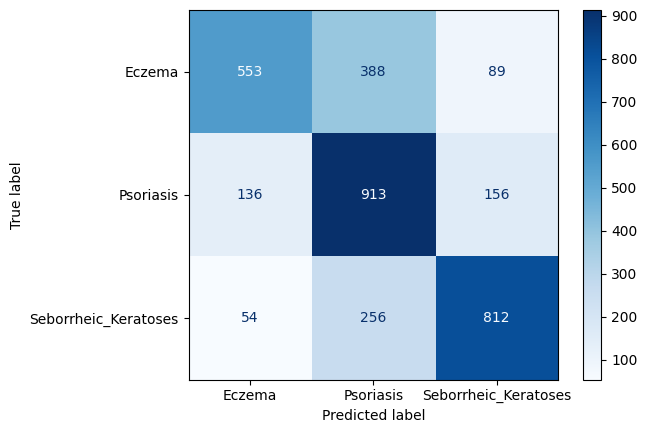

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

# Step 9: Initialize MLflow
mlflow.set_experiment('resnet_experiment')

with mlflow.start_run():
    mlflow.log_param("Model", "ResNet18")

    # Step 10: Train Model with tqdm Progress Bar
    num_epochs = 50
    for epoch in range(num_epochs):
        resnet.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_pred_train = []
        y_true_train = []

        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            resnet = resnet.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and true labels for metrics calculation
            y_pred_train.extend(predicted.cpu().numpy())
            y_true_train.extend(labels.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)


        # Compute per-epoch metrics
        epoch_loss = running_loss / len(train_dataloader)
        epoch_acc = 100 * correct / total
        epoch_precision = precision_score(y_true_train, y_pred_train, average="macro", zero_division=1)
        epoch_recall = recall_score(y_true_train, y_pred_train, average="macro", zero_division=1)
        epoch_f1 = f1_score(y_true_train, y_pred_train, average="macro", zero_division=1)
        epoch_cohen_kappa = cohen_kappa_score(y_true_train, y_pred_train)
        epoch_matthews_corrcoef = matthews_corrcoef(y_true_train, y_pred_train)

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", epoch_loss, step=epoch)
        mlflow.log_metric("train_accuracy", epoch_acc, step=epoch)
        mlflow.log_metric("train_precision", epoch_precision, step=epoch)
        mlflow.log_metric("train_recall", epoch_recall, step=epoch)
        mlflow.log_metric("train_f1_score", epoch_f1, step=epoch)
        mlflow.log_metric("train_cohen_kappa", epoch_cohen_kappa, step=epoch)
        mlflow.log_metric("train_matthews_corrcoef", epoch_matthews_corrcoef, step=epoch)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1-score: {epoch_f1:.4f}")

    # Step 11: Evaluate Model
    resnet.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)

            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Step 12: Compute Final Test Metrics
    classification_rep = classification_report(y_true, y_pred, target_names=dataset.classes, output_dict=True)
    print(classification_rep)
    cm = confusion_matrix(y_true, y_pred)

    # Log classification report
    with open("classification_report.txt", "w") as f:
        f.write(str(classification_rep))
    mlflow.log_artifact("classification_report.txt")

    # Log Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap="Blues")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Compute and Log Final Metrics
    test_precision = precision_score(y_true, y_pred, average="macro", zero_division=1)
    test_recall = recall_score(y_true, y_pred, average="macro", zero_division=1)
    test_f1 = f1_score(y_true, y_pred, average="macro", zero_division=1)
    test_cohen_kappa = cohen_kappa_score(y_true, y_pred)
    test_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1_score", test_f1)
    mlflow.log_metric("test_cohen_kappa", test_cohen_kappa)
    mlflow.log_metric("test_matthews_corrcoef", test_matthews_corrcoef)

    # Log the trained model
    mlflow.pytorch.log_model(resnet, "model")

    print("\nFinal Test Accuracy:", 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true))
    print(f"Cohen Kappa: {test_cohen_kappa:.4f}")
    print(f"Matthews Correlation Coefficient: {test_matthews_corrcoef:.4f}")
    print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")


In [25]:
import torch

def sensitivity_specificity(predictions, targets, num_classes):
    """
    Calculates sensitivity and specificity for multi-class classification.

    Args:
        predictions (torch.Tensor): Predicted probabilities or logits of shape (batch_size, num_classes).
        targets (torch.Tensor): Ground truth labels of shape (batch_size).
        num_classes (int): Number of classes.

    Returns:
        tuple: Sensitivity and specificity, each a tensor of shape (num_classes).
    """

    # Convert predictions to class labels if necessary
    if predictions.shape[-1] != 1:  # Check if predictions are probabilities/logits
        predictions = torch.argmax(predictions, dim=1)

    # Create confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for t, p in zip(targets.view(-1), predictions.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    # Calculate sensitivity and specificity
    sensitivity = torch.zeros(num_classes)
    specificity = torch.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i].item()
        fn = torch.sum(confusion_matrix[i, :]).item() - tp
        fp = torch.sum(confusion_matrix[:, i]).item() - tp
        tn = torch.sum(confusion_matrix) - tp - fn - fp

        sensitivity[i] = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
        specificity[i] = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero

    return sensitivity, specificity

# Example usage
predictions = torch.tensor([[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.1, 0.1, 0.8]])
targets = torch.tensor([0, 1, 2])
num_classes = 3

sensitivity, specificity = sensitivity_specificity(predictions, targets, num_classes)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: tensor([1., 1., 1.])
Specificity: tensor([1., 1., 1.])
